In [1]:
import pandas as pd
import numpy as np
import torch as th
import zipfile
# from tqdm.auto import tqdm, trange # original
from tqdm.notebook import tqdm, trange # fix for newline issue?
from glob import glob
from joblib import delayed, Parallel
import matplotlib.pyplot as plt
import torch_geometric as pyg
import zipfile, os
import torch
import copy
from torch import nn
import networkx as nx
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm.auto import trange
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import interp1d
from sklearn.neighbors import KNeighborsRegressor,RadiusNeighborsRegressor

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Using device:", device)
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print("Using device:", device)

import torch
import torch_geometric as pyg
from torch_geometric.loader import DataLoader # fix
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import MessagePassing
from torch.nn import Sequential as Seq, Linear, ReLU, Sigmoid
from torch_geometric.nn import global_mean_pool
import torch.optim as optim
import joblib
import gc
from scipy.optimize import root_scalar

pd.set_option("display.max_columns", 100)
PATH_DATA0 = '../data/00.01'
PATH_DATA = '../data/00.02'
RANDOM_SEED =0
np.random.seed(RANDOM_SEED)  
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Using device: mps


# Hyperparameters

In [2]:
CRITERION = nn.BCEWithLogitsLoss().to(device)
LR = 0.001
TOLERANCE = 20
LR_TOLERANCE= 5
MAX_EPOCHS = 1
BATCH_SIZE = 32

# Loaders

In [3]:
# loader_train = pyg.loader.DataLoader(
#     pd.read_pickle(os.path.join(PATH_DATA0, 'graphs','max_prob_10_subsample_0.1','graphs_train.pkl')).tolist(),
#     batch_size = BATCH_SIZE,shuffle = True)
# loader_val = pyg.loader.DataLoader(
#     pd.read_pickle(os.path.join(PATH_DATA0, 'graphs','max_prob_10_subsample_0.1','graphs_val.pkl')).tolist(),batch_size = BATCH_SIZE
#     ,shuffle = False)
# loader_test = pyg.loader.DataLoader(
#     pd.read_pickle(os.path.join(PATH_DATA0, 'graphs','max_prob_10_subsample_0.1','graphs_test.pkl')).tolist(),batch_size = BATCH_SIZE
#     ,shuffle = False)

In [4]:
loader_train = DataLoader(
    pd.read_pickle(os.path.join(PATH_DATA0, 'graphs','max_prob_10_subsample_0.1','graphs_train.pkl')).tolist(),
    batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
loader_val = DataLoader(
    pd.read_pickle(os.path.join(PATH_DATA0, 'graphs','max_prob_10_subsample_0.1','graphs_val.pkl')).tolist(),
    batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
loader_test = DataLoader(
    pd.read_pickle(os.path.join(PATH_DATA0, 'graphs','max_prob_10_subsample_0.1','graphs_test.pkl')).tolist(),
    batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

# Model Architecture

In [10]:
# x: 3 node features
# edge_index: graph connectivity
# edge_attr: unused here
class DGCNN(nn.Module):
    def __init__(self, num_node_features, num_edge_features, num_classes, num_layers=3, hidden_mult=1, device='cpu'):
        super(DGCNN, self).__init__()
        self.num_node_features = num_node_features
        self.num_edge_features = num_edge_features
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.device = device
        self.no_cuda = True if device == 'cpu' else True if self.device == 'mps' else False
        self.hidden_mult = hidden_mult


        # feature_dim_map = {
        #     1: int(64 * hidden_mult),
        #     2: int(128 * hidden_mult),
        #     3: int(256 * hidden_mult),
        #     4: int(512 * hidden_mult),
        #     5: int(1024 * hidden_mult)
        # }

        # edgeconv_out_dim = 128
        edgeconv_out_dim = self._ndim_map(hidden_mult if hidden_mult > 1 else 1)

        self.layers = nn.ModuleList()
        # self.layers.append(
        #     pyg.nn.EdgeConv(nn.Sequential(
        #         nn.Linear(num_node_features * 2, 64),
        #         nn.ReLU(),
        #         # nn.Linear(64, 128),
        #         nn.Linear(64, edgeconv_out_dim),
        #         nn.ReLU()
        #     ))
        # )
        # subsequent EdgeConv layers
        prev_out_dim = edgeconv_out_dim
        for i in range(1, num_layers + 1):
            print(f"DEBUG: i = {i}")
            if i == 1 and num_layers > 1:
                print("first layer, num_layers > 1")
                next_out_dim = self._ndim_map(i + 1)
                self.layers.append(
                    pyg.nn.EdgeConv(nn.Sequential(
                        nn.Linear(num_node_features * 2, prev_out_dim),
                        nn.ReLU(),
                        nn.Linear(prev_out_dim, next_out_dim),
                        nn.ReLU()
                    ))
                )
                prev_out_dim = next_out_dim
            elif i == 1 and num_layers == 1:
                print("first layer, num_layers == 1")
                self.layers.append(
                    pyg.nn.EdgeConv(nn.Sequential(
                        nn.Linear(num_node_features * 2, prev_out_dim),
                        nn.ReLU(),
                        nn.Linear(prev_out_dim, 128),
                        nn.ReLU()
                    ))
                )
                # The output of this single layer is 128 dims
                prev_out_dim = 128
                edgeconv_out_dim = prev_out_dim  # keep edgeconv_out_dim for logging
            elif i > 1 and i < num_layers:
                print("middle layer")
                next_out_dim = self._ndim_map(i + 1)
                self.layers.append(
                    pyg.nn.EdgeConv(nn.Sequential(
                        nn.Linear(prev_out_dim * 2, prev_out_dim),
                        nn.ReLU(),
                        nn.Linear(prev_out_dim, next_out_dim),
                        nn.ReLU()
                    ))
                )
                prev_out_dim = next_out_dim
            elif i > 1 and  i == num_layers:
                print("last layer")
                next_out_dim = self._ndim_map(i + 1)
                self.layers.append(
                    pyg.nn.EdgeConv(nn.Sequential(
                        nn.Linear(prev_out_dim * 2, prev_out_dim),
                        nn.ReLU(),
                        nn.Linear(prev_out_dim, 128),
                        nn.ReLU()
                    ))
                )
                # update prev_out_dim to match this final layer's output
                prev_out_dim = 128
            else:
                print(f"DEBUG: i = {i}")
                print("Bad state in EdgeConv layer creation")
                # next_out_dim = self._ndim_map(i + 1)
                # self.layers.append(
                #     pyg.nn.EdgeConv(nn.Sequential(
                #         nn.Linear(prev_out_dim, prev_out_dim),
                #         nn.ReLU(),
                #         nn.Linear(prev_out_dim, next_out_dim),
                #         nn.ReLU()
                #     ))
                # )
                # prev_out_dim = next_out_dim
        print(f"DEBUG: edgeconv_out_dim = {edgeconv_out_dim}")
        print(f"DEBUG: prev_out_dim = {prev_out_dim}")

        # Edge-level fully connected layers
        self.fc1 = nn.Linear(prev_out_dim * 2, 128, device=device)
        self.fc2 = nn.Linear(128, num_classes, device=device)

        # Move model to the designated device
        self.to(device)

    def _ndim_map(self, n):
        # 1: 64
        # 2: 128
        # 3: 256
        # 4: 512
        # 5: 1024
        # 6: 2048
        # 7: 4096
        if n < 1:
            raise ValueError("n must be at least 1")
        if n % 1 != 0:
            raise ValueError("n must be an integer")
        return 2**(5+n) * int(self.hidden_mult)

    # def _init_weights(self, m):
    #     if isinstance(m, nn.Linear):
    #         nn.init.xavier_uniform_(m.weight)
    #         if m.bias is not None:
    #             nn.init.zeros_(m.bias)
    #     elif isinstance(m, nn.Conv1d):
    #         nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
    #         if m.bias is not None:
    #             nn.init.zeros_(m.bias)
    #     elif isinstance(m, nn.BatchNorm1d):
    #         nn.init.ones_(m.weight)
    #         nn.init.zeros_(m.bias)
    #     elif isinstance(m, nn.LayerNorm):
    #         nn.init.ones_(m.weight)
    #         nn.init.zeros_(m.bias)

    def forward(self, data):
        x, edge_index = data.x.to(self.device), data.edge_index.to(self.device)

        # Apply EdgeConv layers to get node embeddings
        for conv in self.layers[:self.num_layers]:
            x = conv(x, edge_index)

        # Edge-level predictions: concatenate features of each edge's endpoints
        row, col = edge_index
        edge_emb = torch.cat([x[row], x[col]], dim=1)

        # Pass through MLP
        edge_h = F.relu(self.fc1(edge_emb))
        edge_out = self.fc2(edge_h)

        # Return one output per edge
        return torch.sigmoid(edge_out).squeeze(-1)



In [11]:
# class RelationalModel(nn.Module):
#     def __init__(self, input_size, output_size, hidden_size, n_layers):
#         super(RelationalModel, self).__init__()

#         layers = [nn.Linear(input_size, hidden_size), 
#                  nn.ReLU()]
#         if n_layers>=2:
#             for _ in range(n_layers - 1):
#                 layers.append(nn.Linear(hidden_size, hidden_size))
#                 layers.append(nn.ReLU())

#         layers.append(nn.Linear(hidden_size, output_size))

#         self.layers = nn.Sequential(*layers)

#     def forward(self, x):
#         return self.layers(x)
# class ObjectModel(nn.Module):
#     def __init__(self, input_size, output_size, hidden_size, n_layers):
#         super(ObjectModel, self).__init__()

#         layers = [nn.Linear(input_size, hidden_size), 
#                  nn.ReLU()]
#         if n_layers>=2:
#             for _ in range(n_layers - 1):
#                 layers.append(nn.Linear(hidden_size, hidden_size))
#                 layers.append(nn.ReLU())

#         layers.append(nn.Linear(hidden_size, output_size))

#         self.layers = nn.Sequential(*layers)

#     def forward(self, C):
#         return self.layers(C)
# class InteractionNetwork(MessagePassing):
#     def __init__(self, hidden_size, n_layers):
#         super(InteractionNetwork, self).__init__(aggr='add', 
#                                                  flow='source_to_target')
#         self.R1 = RelationalModel(10, 4, hidden_size, n_layers)
#         self.O = ObjectModel(7, 3, hidden_size, n_layers)
#         self.R2 = RelationalModel(10, 1, hidden_size, n_layers)
#         self.E: Tensor = Tensor()

#     def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor) -> Tensor:

#         # propagate_type: (x: Tensor, edge_attr: Tensor)
#         x_tilde = self.propagate(edge_index, x=x, edge_attr=edge_attr, size=None)

#         m2 = torch.cat([x_tilde[edge_index[1]],
#                         x_tilde[edge_index[0]],
#                         self.E], dim=1)
#         return self.R2(m2)

#     def message(self, x_i, x_j, edge_attr):
#         # x_i --> incoming
#         # x_j --> outgoing        
#         m1 = torch.cat([x_i, x_j, edge_attr], dim=1)
#         self.E = self.R1(m1)
#         return self.E

#     def update(self, aggr_out, x):
#         c = torch.cat([x, aggr_out], dim=1)
#         return self.O(c) 

# Functions

In [ ]:
def count_parameters(model):
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return trainable_params

def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

def load_model(model, path):
    model.load_state_dict(torch.load(path))
    model.eval()
    print(f"Model loaded from {path}")
    return model

def evaluate(model, loader):
    model.eval()
    preds, actuals = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            # turn node-y into graph-y
            y_nodes = batch.y.float().unsqueeze(-1)  # [num_nodes,1]
            # manual pooling using batch.ptr
            ptr = batch.ptr  # shape [num_graphs+1]
            # compute mean of y_nodes for each graph
            y_graph = torch.cat([
                y_nodes[ptr[i]:ptr[i+1]].mean(dim=0, keepdim=True)
                for i in range(ptr.size(0) - 1)
            ], dim=0).squeeze(-1)
            preds.append(out)
            actuals.append(y_graph)
        preds = torch.cat(preds, dim=0)
        actuals = torch.cat(actuals, dim=0)
        acc = ((torch.sigmoid(preds)>0.5)==(actuals>0.5)).float().mean().item()
        print([(p.item(), a.item()) for p, a in zip(preds, actuals)])
        print(f"preds: {preds}, actuals: {actuals}, acc: {acc}")
        entropy = CRITERION(preds, actuals).item()
    model.train()
    return preds.cpu().numpy(), actuals.cpu().numpy(), acc, entropy

def train_epoch(model, loader_train, optimizer):
    model.train()
    print("Running on ", next(model.parameters()).device)
    train_loss = 0.0
    for batch in tqdm(loader_train, leave=False):
        batch = batch.to(device)
        # Ensure key graph tensors are on the target device
        if hasattr(batch, 'x') and isinstance(batch.x, torch.Tensor):
            assert str(batch.x.device).startswith(str(device)), f"batch.x on {batch.x.device}, expected {device}"
        if hasattr(batch, 'edge_index') and isinstance(batch.edge_index, torch.Tensor):
            assert str(batch.edge_index.device).startswith(str(device)), f"batch.edge_index on {batch.edge_index.device}, expected {device}"
        if hasattr(batch, 'edge_attr') and isinstance(batch.edge_attr, torch.Tensor):
            assert str(batch.edge_attr.device).startswith(str(device)), f"batch.edge_attr on {batch.edge_attr.device}, expected {device}"
        if hasattr(batch, 'batch') and isinstance(batch.batch, torch.Tensor):
            assert str(batch.batch.device).startswith(str(device)), f"batch.batch on {batch.batch.device}, expected {device}"
        if hasattr(batch, 'y') and isinstance(batch.y, torch.Tensor):
            assert str(batch.y.device).startswith(str(device)), f"batch.y on {batch.y.device}, expected {device}"
        optimizer.zero_grad()
        print(f"batch: {batch}")
        out = model(batch)                # [batch_size,1]
        # graph-level target
        y_nodes = batch.y.float().unsqueeze(-1)     # [num_nodes,1]
        y_edges = batch.y.float()     # [num_edges,1]
        # manual pooling using batch.ptr
        ptr = batch.ptr
        y_graph = torch.cat([
            y_nodes[ptr[i]:ptr[i+1]].mean(dim=0, keepdim=True)
            for i in range(ptr.size(0) - 1)
        ], dim=0).squeeze(-1)
        print(f"out: {out}, y_graph: {y_graph}")
        print(f"out.shape: {out.shape}, y_graph.shape: {y_graph.shape}")
        loss = CRITERION(out, y_graph)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch.num_graphs
    return train_loss / len(loader_train)

In [46]:
data = loader_train.dataset
n = 0
for g in data:
    n += len(g.y)

print(n)

17826812


In [13]:
N_LAYERS = 2
HIDDEN_MULT = 1

# Numper of parameters
print("Number of parameters in model: ", count_parameters(DGCNN(3, 4, 1, N_LAYERS, HIDDEN_MULT).to(device)))

DEBUG: i = 1
first layer, num_layers > 1
DEBUG: i = 2
last layer
DEBUG: edgeconv_out_dim = 64
DEBUG: prev_out_dim = 128
Number of parameters in model:  91201


# Train

In [35]:
# Simplified training loop
def train_model(model, loader_train, loader_val, num_epochs=MAX_EPOCHS, lr=LR):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # for name, p in model.named_parameters():
    #     print(f"{name}: {p.device}")
    print(model.layers)
    best_val_acc = 0.0
    best_model = None
    train_losses = []
    val_accs = []
    val_entropies = []
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, loader_train, optimizer)
        val_preds, val_actuals, val_acc, val_entropy = evaluate(model, loader_val)
        train_losses.append(train_loss)
        val_accs.append(val_acc)
        val_entropies.append(val_entropy)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = copy.deepcopy(model)
            save_model(best_model, os.path.join(PATH_DATA, f"best_model_epoch_{epoch+1}.pth"))
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Acc: {val_acc:.4f}, Val Entropy: {val_entropy:.4f}")

        # for name, p in model.named_parameters():
        #     print(f"{name}: {p.device}")
    return best_model, train_losses, val_accs, val_entropies

def plot_training(train_losses, val_accs, val_entropies):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(val_entropies, label='Val Entropy')
    plt.xlabel('Epoch')
    plt.ylabel('Entropy')
    plt.title('Validation Entropy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

def load_model(model, path):
    model.load_state_dict(torch.load(path))
    model.eval()
    print(f"Model loaded from {path}")

def predict(model, loader):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for data in loader:
            preds = model(data)
            all_preds.append(preds)
    return torch.cat(all_preds, dim=0)

# Run training
model, train_losses, val_accs, val_entropies = train_model(
    model=DGCNN(num_node_features=3, num_edge_features=4, num_classes=1, num_layers=N_LAYERS, hidden_mult=HIDDEN_MULT, device=device),
    loader_train=loader_train,
    loader_val=loader_val,
    num_epochs=MAX_EPOCHS,
    lr=LR
)


DEBUG: i = 1
first layer, num_layers > 1
DEBUG: i = 2
last layer
DEBUG: edgeconv_out_dim = 64
DEBUG: prev_out_dim = 128
ModuleList(
  (0): EdgeConv(nn=Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
  ))
  (1): EdgeConv(nn=Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
  ))
)
Running on  mps:0


  0%|          | 0/18 [00:00<?, ?it/s]

batch: DataBatch(x=[88156, 3], edge_index=[2, 1014522], edge_attr=[1014522, 4], y=[1014522, 1], hit_ids=[88156], particle_ids=[88156], batch=[88156], ptr=[33])
out: tensor([0.4910, 0.4914, 0.4915,  ..., 0.4907, 0.4902, 0.4896], device='mps:0',
       grad_fn=<SqueezeBackward1>), y_graph: tensor([[0.9450],
        [0.8643],
        [0.7682],
        [0.8444],
        [0.9125],
        [0.9763],
        [0.9294],
        [0.8789],
        [0.8783],
        [0.8528],
        [0.9524],
        [0.8957],
        [0.6589],
        [0.7381],
        [0.7786],
        [0.8345],
        [0.9217],
        [0.9311],
        [0.8427],
        [0.8317],
        [0.8415],
        [0.8161],
        [0.8915],
        [0.7960],
        [0.8633],
        [0.9693],
        [0.9366],
        [0.6261],
        [0.7637],
        [0.7911],
        [0.8473],
        [0.9631]], device='mps:0')
out.shape: torch.Size([1014522]), y_graph.shape: torch.Size([32, 1])


ValueError: Target size (torch.Size([32, 1])) must be the same as input size (torch.Size([1014522]))

In [45]:
model = DGCNN(num_node_features=3, num_edge_features=4, num_classes=1, device=device, num_layers=3, hidden_mult=1)
print(f"Number of parameters in the model: {count_parameters(model)}")
model.layers

DEBUG: i = 1
first layer, num_layers > 1
DEBUG: i = 2
last layer
DEBUG: edgeconv_out_dim = 64
DEBUG: prev_out_dim = 128
Number of parameters in the model: 74817


ModuleList(
  (0): EdgeConv(nn=Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
  ))
  (1): EdgeConv(nn=Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
  ))
)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Layers: 2
Target Params: 100000
DEBUG: i = 1
first layer, num_layers > 1
DEBUG: i = 2
last layer
DEBUG: edgeconv_out_dim = 64
DEBUG: prev_out_dim = 128
Hidden Mult: 1.0, Params: -25183
DEBUG: i = 1
first layer, num_layers > 1
DEBUG: i = 2
last layer
DEBUG: edgeconv_out_dim = 2048
DEBUG: prev_out_dim = 128
Hidden Mult: 4.0, Params: 1570529
DEBUG: i = 1
first layer, num_layers > 1
DEBUG: i = 2
last layer
DEBUG: edgeconv_out_dim = 256
DEBUG: prev_out_dim = 128
Hidden Mult: 2.5, Params: 148449
DEBUG: i = 1
first layer, num_layers > 1
DEBUG: i = 2
last layer
DEBUG: edgeconv_out_dim = 64
DEBUG: prev_out_dim = 128
Hidden Mult: 1.75, Params: -25183
DEBUG: i = 1
first layer, num_layers > 1
DEBUG: i = 2
last layer
DEBUG: edgeconv_out_dim = 256
DEBUG: prev_out_dim = 128
Hidden Mult: 2.125, Params: 148449
DEBUG: i = 1
first layer, num_layers > 1
DEBUG: i = 2
last layer
DEBUG: edgeconv_out_dim = 64
DEBUG: prev_out_dim = 128
Hidden Mult: 1.9375, Params: -25183
DEBUG: i = 1
first layer, num_layers > 

  0%|          | 0/1 [00:00<?, ?it/s]

Running on  mps:0


  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG: x_pool shape before fc1 = torch.Size([32, 128])
DEBUG: x_out shape = torch.Size([32, 1])
tensor([[0.0629],
        [0.0625],
        [0.0626],
        [0.0628],
        [0.0629],
        [0.0629],
        [0.0626],
        [0.0628],
        [0.0630],
        [0.0632],
        [0.0628],
        [0.0628],
        [0.0631],
        [0.0631],
        [0.0627],
        [0.0627],
        [0.0627],
        [0.0626],
        [0.0627],
        [0.0630],
        [0.0629],
        [0.0626],
        [0.0630],
        [0.0630],
        [0.0630],
        [0.0625],
        [0.0631],
        [0.0628],
        [0.0625],
        [0.0630],
        [0.0628],
        [0.0627]], device='mps:0', grad_fn=<LinearBackward0>)
DEBUG: x_pool shape before fc1 = torch.Size([32, 128])
DEBUG: x_out shape = torch.Size([32, 1])
tensor([[0.1404],
        [0.1436],
        [0.1395],
        [0.1418],
        [0.1390],
        [0.1399],
        [0.1392],
        [0.1403],
        [0.1402],
        [0.1408],
        

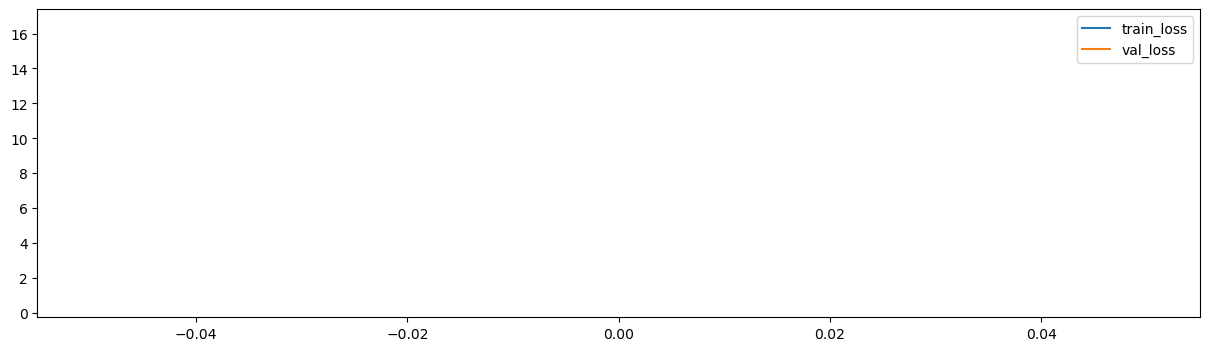

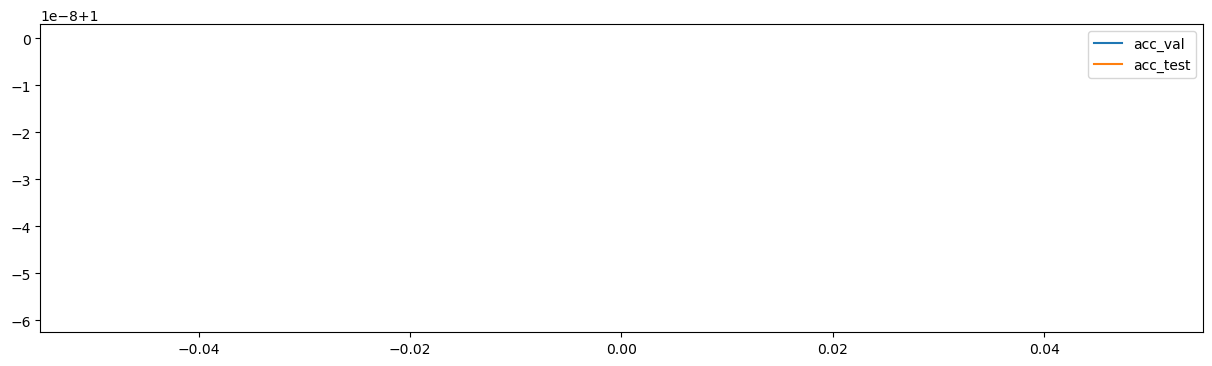

Layers: 2
Target Params: 500000
DEBUG: i = 1
first layer, num_layers > 1
DEBUG: i = 2
last layer
DEBUG: edgeconv_out_dim = 64
DEBUG: prev_out_dim = 128
Hidden Mult: 1.0, Params: -425183
DEBUG: i = 1
first layer, num_layers > 1
DEBUG: i = 2
last layer
DEBUG: edgeconv_out_dim = 2048
DEBUG: prev_out_dim = 128
Hidden Mult: 4.0, Params: 1170529
DEBUG: i = 1
first layer, num_layers > 1
DEBUG: i = 2
last layer
DEBUG: edgeconv_out_dim = 256
DEBUG: prev_out_dim = 128
Hidden Mult: 2.5, Params: -251551
DEBUG: i = 1
first layer, num_layers > 1
DEBUG: i = 2
last layer
DEBUG: edgeconv_out_dim = 768
DEBUG: prev_out_dim = 128
Hidden Mult: 3.25, Params: 161889
DEBUG: i = 1
first layer, num_layers > 1
DEBUG: i = 2
last layer
DEBUG: edgeconv_out_dim = 256
DEBUG: prev_out_dim = 128
Hidden Mult: 2.875, Params: -251551
DEBUG: i = 1
first layer, num_layers > 1
DEBUG: i = 2
last layer
DEBUG: edgeconv_out_dim = 768
DEBUG: prev_out_dim = 128
Hidden Mult: 3.0625, Params: 161889
DEBUG: i = 1
first layer, num_laye

  0%|          | 0/1 [00:00<?, ?it/s]

Running on  mps:0


  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG: x_pool shape before fc1 = torch.Size([32, 128])
DEBUG: x_out shape = torch.Size([32, 1])
tensor([[-0.0186],
        [-0.0184],
        [-0.0185],
        [-0.0185],
        [-0.0181],
        [-0.0184],
        [-0.0185],
        [-0.0187],
        [-0.0184],
        [-0.0183],
        [-0.0182],
        [-0.0189],
        [-0.0182],
        [-0.0182],
        [-0.0185],
        [-0.0183],
        [-0.0185],
        [-0.0183],
        [-0.0187],
        [-0.0186],
        [-0.0184],
        [-0.0179],
        [-0.0182],
        [-0.0185],
        [-0.0184],
        [-0.0186],
        [-0.0183],
        [-0.0183],
        [-0.0184],
        [-0.0181],
        [-0.0184],
        [-0.0186]], device='mps:0', grad_fn=<LinearBackward0>)
DEBUG: x_pool shape before fc1 = torch.Size([32, 128])
DEBUG: x_out shape = torch.Size([32, 1])
tensor([[0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0

RuntimeError: MPS backend out of memory (MPS allocated: 30.54 GB, other allocations: 5.24 GB, max allowed: 36.27 GB). Tried to allocate 512.94 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [54]:
def print_model_summary(model):
    print("Model Summary:")
    print("-" * 50)
    print(f"Model Type: {type(model).__name__}")
    print(f"Number of Layers: {model.num_layers}")
    print(f"Number of Parameters: {count_parameters(model)}")
    print(f"Device: {model.device}")
    print("-" * 50)
    print("Layer Details:")
    print(model.layers)

nom_args = (3, 4, 1)

def f(n_layers, target_params):
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    print(f"Layers: { n_layers }")
    print(f"Target Params: { target_params }")
    # Find out the hyperparameteres yielding #params = target_params
    def objective(h):
        out = count_parameters(DGCNN(*nom_args, hidden_mult=int(h), num_layers=n_layers, device=device)) - target_params
        print(f"Hidden Mult: {h}, Params: {out}")
        return out
    
    optimal_h = int(root_scalar(objective, bracket=[1, 4], method='bisect').root)
    print(f"(1) Optimal h: {optimal_h}")
    # optimal_h= pd.Series({optimal_h:target_params-count_parameters(DGCNN(*nom_args, hidden_mult=optimal_h, num_layers=n_layers)),
    #             optimal_h-1:target_params-count_parameters(DGCNN(*nom_args, hidden_mult=optimal_h-1, num_layers=n_layers)),
    #             optimal_h+1:target_params-count_parameters(DGCNN(*nom_args, hidden_mult=optimal_h+1, num_layers=n_layers))}).abs().idxmin()
    # print(f"(2) Optimal h: {optimal_h}")
    
    # model = DGCNN(optimal_h,n_layers).to(device) 
    # model = InteractionNetwork(optimal_h,n_layers).to(device)
    model = DGCNN(*nom_args, hidden_mult=optimal_h, num_layers=n_layers, device=device)
    print_model_summary(model)
    lr = LR
    optimizer = optim.Adam(model.parameters(), lr=LR)
    best_val_loss = float('inf')
    epochs_no_improve, epochs_no_improve2 = 0,0
    best_model_state = None
    stats = []
    best = None
    # Print header once
    print(f"{'Epoch':>5} | {'Train Loss':>10} | {'Val Loss':>9} | {'Val Acc':>8} | {'Test Acc':>9}")
    print("-" * 50)
    for epoch in trange(MAX_EPOCHS):
        train_loss = train_epoch(model, loader_train, optimizer)   
        preds_val, actuals_val, acc_val, val_loss = evaluate(model,loader_val)
        preds_test, actuals_test, acc_test, test_loss = evaluate(model,loader_test)
        
        stats.append({'train_loss':train_loss, 'val_loss':val_loss, 'acc_val':acc_val, 'acc_test':acc_test})
        if val_loss < best_val_loss: 
            print(f"{epoch+1:5d} | {train_loss:10.4f} | {val_loss:9.4f} | {acc_val:8.4f} | {acc_test:9.4f} *")
            best_val_loss = val_loss
            epochs_no_improve = 0
            epochs_no_improve2 = 0
            best = {'model_state': {k: v.cpu() for k, v in model.state_dict().items()},
                    'preds_test':preds_test, 'preds_val':preds_val}        
        else:
            print(f"{epoch+1:5d} | {train_loss:10.4f} | {val_loss:9.4f} | {acc_val:8.4f} | {acc_test:9.4f}")
            epochs_no_improve += 1
            epochs_no_improve2 += 1

        if epochs_no_improve >= TOLERANCE:
            print(f"Early stopping at epoch {epoch+1}")
            break
        if epochs_no_improve2 >= LR_TOLERANCE:
            if lr >=1.0e-8:
                lr/=10
            print(f"LR reduction to {lr}")
    best['stats'] = stats
    os.makedirs(PATH_DATA, exist_ok=True)
    joblib.dump(best, os.path.join(PATH_DATA, f"L{n_layers}.pkl"))
    
    stats = pd.DataFrame(stats)
    stats[['train_loss','val_loss']].plot(figsize = (15,4))
    plt.show()
    stats[['acc_val','acc_test']].plot(figsize = (15,4))
    plt.show()
    del model
    del train_loss
    del optimizer

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        
Parallel(n_jobs=1)(delayed(f)(n_layers, target_params)
                    for n_layers in tqdm([2,3])
                    for target_params in tqdm([100_000, 500_000, 10_000]))
                    # for target_params in tqdm([1_000_000, 100_000, 500_000, 10_000]))

In [47]:
def objective(h):
    print(f"Params: {count_parameters(DGCNN(*nom_args, hidden_mult=h, num_layers=2, device=device))}")
    out = count_parameters(DGCNN(*nom_args, hidden_mult=h, num_layers=1, device=device)) - 1_000
    print(f"Hidden Mult: {h}, Params: {out}")
    return out


_h = 1 # init
step = 0.1
if objective(_h) < 0 and _h >= 1:
    while objective(_h) > 0:
        _h -= step if _h > 1 else 0
        print(f"Hidden Mult: {_h}, Params: {objective(_h)}")
elif objective(_h) > 0:
    while objective(_h) < 0:
        _h += step
        print(f"Hidden Mult: {_h}, Params: {objective(_h)}")
print(f"Hidden Mult: {_h}, Params: {objective(_h)}")

optimal_h = root_scalar(objective, bracket=[1, 10], method='bisect').root

DEBUG: i = 1
first layer, num_layers > 1
DEBUG: i = 2
last layer
DEBUG: edgeconv_out_dim = 64
DEBUG: prev_out_dim = 128
Params: 74817
DEBUG: i = 1
first layer, num_layers == 1
DEBUG: edgeconv_out_dim = 128
DEBUG: prev_out_dim = 128
Hidden Mult: 1, Params: 24409
DEBUG: i = 1
first layer, num_layers > 1
DEBUG: i = 2
last layer
DEBUG: edgeconv_out_dim = 64
DEBUG: prev_out_dim = 128
Params: 74817
DEBUG: i = 1
first layer, num_layers == 1
DEBUG: edgeconv_out_dim = 128
DEBUG: prev_out_dim = 128
Hidden Mult: 1, Params: 24409
DEBUG: i = 1
first layer, num_layers > 1
DEBUG: i = 2
last layer
DEBUG: edgeconv_out_dim = 64
DEBUG: prev_out_dim = 128
Params: 74817
DEBUG: i = 1
first layer, num_layers == 1
DEBUG: edgeconv_out_dim = 128
DEBUG: prev_out_dim = 128
Hidden Mult: 1, Params: 24409
DEBUG: i = 1
first layer, num_layers > 1
DEBUG: i = 2
last layer
DEBUG: edgeconv_out_dim = 64
DEBUG: prev_out_dim = 128
Params: 74817
DEBUG: i = 1
first layer, num_layers == 1
DEBUG: edgeconv_out_dim = 128
DEBUG: p

TypeError: empty() received an invalid combination of arguments - got (tuple, dtype=NoneType, device=NoneType), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.memory_format memory_format = None, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)
 * (tuple of ints size, *, torch.memory_format memory_format = None, Tensor out = None, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)


In [53]:
def f(n_layers,target_params):
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    print(n_layers, target_params)
    # Find out the hyperparameteres yielding #params = target_params
    def objective(h):
        return count_parameters(InteractionNetwork(int(h),n_layers)) - target_params
    
    optimal_h = int(root_scalar(objective, bracket=[1, 50000], method='bisect').root)
    print(f"(1) Optimal h: {optimal_h}")

    optimal_h= pd.Series({optimal_h:target_params-count_parameters(InteractionNetwork(optimal_h, n_layers)),
                optimal_h-1:target_params-count_parameters(InteractionNetwork(optimal_h-1,n_layers)),
                optimal_h+1:target_params-count_parameters(InteractionNetwork(optimal_h+1,n_layers))}).abs().idxmin()
    print(f"(2) Optimal h: {optimal_h}")
    
    # model = InteractionNetwork(optimal_h,n_layers).to(device)
    model = DGCNN(3, 4, 1).to(device)
    lr = LR
    optimizer = optim.Adam(model.parameters(), lr=LR)
    best_val_loss = float('inf')
    epochs_no_improve, epochs_no_improve2 = 0,0
    best_model_state = None
    stats = []
    best = None
    # Print header once
    print(f"{'Epoch':>5} | {'Train Loss':>10} | {'Val Loss':>9} | {'Val Acc':>8} | {'Test Acc':>9}")
    print("-" * 50)
    for epoch in trange(MAX_EPOCHS):
        train_loss = train_epoch(model, loader_train, optimizer)   
        preds_val, actuals_val, acc_val, val_loss = evaluate(model,loader_val)
        preds_test, actuals_test, acc_test, test_loss = evaluate(model,loader_test)
        
        stats.append({'train_loss':train_loss, 'val_loss':val_loss, 'acc_val':acc_val, 'acc_test':acc_test})
        if val_loss < best_val_loss: 
            print(f"{epoch+1:5d} | {train_loss:10.4f} | {val_loss:9.4f} | {acc_val:8.4f} | {acc_test:9.4f} *")
            best_val_loss = val_loss
            epochs_no_improve = 0
            epochs_no_improve2 = 0
            best = {'model_state': {k: v.cpu() for k, v in model.state_dict().items()},
                    'preds_test':preds_test, 'preds_val':preds_val}        
        else:
            print(f"{epoch+1:5d} | {train_loss:10.4f} | {val_loss:9.4f} | {acc_val:8.4f} | {acc_test:9.4f}")
            epochs_no_improve += 1
            epochs_no_improve2 += 1

        if epochs_no_improve >= TOLERANCE:
            print(f"Early stopping at epoch {epoch+1}")
            break
        if epochs_no_improve2 >= LR_TOLERANCE:
            if lr >=1.0e-8:
                lr/=10
            print(f"LR reduction to {lr}")
    best['stats'] = stats
    os.makedirs(PATH_DATA, exist_ok=True)
    joblib.dump(best, os.path.join(PATH_DATA, f"{n_layers}_{target_params}.pkl"))
    
    stats = pd.DataFrame(stats)
    stats[['train_loss','val_loss']].plot(figsize = (15,4))
    plt.show()
    stats[['acc_val','acc_test']].plot(figsize = (15,4))
    plt.show()
    del model
    del train_loss
    del optimizer

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        
Parallel(n_jobs=1)(delayed(f)(n_layers,target_params)
                    for n_layers in tqdm([2,3,4])
                    for target_params in tqdm([1_000_000,100_000,
                                               500_000,]))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

2 1000000


KeyboardInterrupt: 

# Summary of the Results

In [14]:
val = pd.read_pickle(os.path.join(PATH_DATA0, 'graphs','max_prob_10_subsample_0.1','graphs_val.pkl'))
test = pd.read_pickle(os.path.join(PATH_DATA0, 'graphs','max_prob_10_subsample_0.1','graphs_test.pkl'))
val_y = torch.cat([i.y for i in val.values]).numpy()
test_y = torch.cat([i.y for i in test.values]).numpy()

In [60]:
model.eval()
val0 = next(iter(loader_val))
preds = model(val0)


DEBUG: x_pool shape before fc1 = torch.Size([32, 128])
DEBUG: x_out shape = torch.Size([32, 1])
tensor([[0.3406],
        [0.3448],
        [0.3389],
        [0.3434],
        [0.3434],
        [0.3406],
        [0.3394],
        [0.3444],
        [0.3404],
        [0.3401],
        [0.3415],
        [0.3432],
        [0.3387],
        [0.3406],
        [0.3458],
        [0.3404],
        [0.3403],
        [0.3433],
        [0.3371],
        [0.3428],
        [0.3411],
        [0.3404],
        [0.3416],
        [0.3416],
        [0.3391],
        [0.3419],
        [0.3398],
        [0.3416],
        [0.3429],
        [0.3381],
        [0.3400],
        [0.3418]], device='mps:0', grad_fn=<LinearBackward0>)


In [67]:
val0.y.shape

torch.Size([1044834, 1])

In [26]:
# Run inference on model and extract val and test predictions
def run_inference(model, loader):
    model.eval()
    preds = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            preds.append(torch.sigmoid(model(batch).to(device)))
        preds = torch.cat(preds)
    return preds.cpu().numpy()

test_preds = run_inference(model, loader_test)
val_preds = run_inference(model, loader_val)

# Truth values
val_y = torch.cat([i.y for i in loader_val.dataset]).numpy()
test_y = torch.cat([i.y for i in loader_test.dataset]).numpy()

# Accuracy
val_acc = ((val_preds > 0.5) == (val_y > 0.5)).mean()
test_acc = ((test_preds > 0.5) == (test_y > 0.5)).mean()
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

DEBUG: x_pool shape before fc1 = torch.Size([32, 128])
DEBUG: x_out shape = torch.Size([32, 1])
tensor([[0.3429],
        [0.3392],
        [0.3415],
        [0.3425],
        [0.3396],
        [0.3408],
        [0.3416],
        [0.3416],
        [0.3435],
        [0.3417],
        [0.3419],
        [0.3453],
        [0.3422],
        [0.3422],
        [0.3385],
        [0.3410],
        [0.3353],
        [0.3396],
        [0.3411],
        [0.3391],
        [0.3394],
        [0.3378],
        [0.3404],
        [0.3425],
        [0.3424],
        [0.3457],
        [0.3419],
        [0.3394],
        [0.3400],
        [0.3399],
        [0.3399],
        [0.3360]], device='mps:0')
DEBUG: x_pool shape before fc1 = torch.Size([32, 128])
DEBUG: x_out shape = torch.Size([32, 1])
tensor([[0.3424],
        [0.3379],
        [0.3379],
        [0.3374],
        [0.3404],
        [0.3425],
        [0.3387],
        [0.3406],
        [0.3386],
        [0.3364],
        [0.3426],
        [0.3398],

ValueError: operands could not be broadcast together with shapes (141,1) (4435556,1) 

In [39]:
val_preds

array([[0.64206445],
       [0.6422967 ],
       [0.64196926],
       [0.6422225 ],
       [0.6422225 ],
       [0.6420662 ],
       [0.64199936],
       [0.6422756 ],
       [0.6420555 ],
       [0.6420377 ],
       [0.6421128 ],
       [0.6422078 ],
       [0.64195794],
       [0.6420672 ],
       [0.64235276],
       [0.6420513 ],
       [0.64204603],
       [0.64221585],
       [0.64186937],
       [0.6421888 ],
       [0.6420925 ],
       [0.64205223],
       [0.64212006],
       [0.6421229 ],
       [0.6419817 ],
       [0.64213896],
       [0.6420181 ],
       [0.64212203],
       [0.64219075],
       [0.6419237 ],
       [0.64202994],
       [0.64213157],
       [0.6421087 ],
       [0.6421087 ],
       [0.6418728 ],
       [0.64201194],
       [0.64207745],
       [0.64219904],
       [0.6419337 ],
       [0.6422196 ],
       [0.64210004],
       [0.64209455],
       [0.6420129 ],
       [0.6419739 ],
       [0.6419706 ],
       [0.6419245 ],
       [0.64232755],
       [0.642

In [21]:
results = dict()
print(PATH_DATA)
for p in glob(os.path.join(PATH_DATA,'*.pkl')): 
    preds_test = joblib.load(p)['preds_test']>=0.5
    preds_val =joblib.load(p)['preds_val']>=0.5
    print(f"shape preds_test: {preds_test.shape}")
    print(f"shape test_y: {test_y.shape}")
    results[p]={'test_accuracy': (preds_test==test_y).astype(float).mean(),
     'val_accuracy':(preds_val==val_y).astype(float).mean()}
    results = pd.DataFrame(results)
results.columns = [os.path.split(i)[-1].replace('.pkl','') for i in results.columns]
results = results.T.sort_values('val_accuracy', ascending = False)
results.index = pd.MultiIndex.from_tuples([tuple(i.split('_')) for i in results.index])
results.index.names = ['#layers','#params']
results.to_csv(os.path.join(PATH_DATA, 'results.csv'))

../data/00.02
shape preds_test: (177, 1)
shape test_y: (5472684, 1)


ValueError: operands could not be broadcast together with shapes (177,1) (5472684,1) 

In [51]:
results

test_accuracy  val_accuracy
#layers #params                             
4       1000000       0.994750      0.994493
        500000        0.994401      0.994209
3       1000000       0.993834      0.993719
4       100000        0.993913      0.993667
3       500000        0.993656      0.993433
2       1000000       0.992984      0.992853
        500000        0.992865      0.992497
3       100000        0.992658      0.992375
2       100000        0.990710      0.990459

In [52]:
print('The Accuracy', results.iloc[0]['test_accuracy'])

The Accuracy 0.9947501079908871


-----------------------------------

In [7]:
asdfasdfasfd

NameError: name 'asdfasdfasfd' is not defined

In [ ]:


for n_layers in tqdm([3,2,4]): 
    for target_params in tqdm([100_000,500_000,1_000_000]): 
        print(n_layers, target_params)
        # Find out the hyperparameteres yielding #params = target_params
        def objective(h):
            return count_parameters(InteractionNetwork(int(h),n_layers)) - target_params
        optimal_h = int(root_scalar(objective, bracket=[1, 3000], method='bisect').root)
        optimal_h= pd.Series({optimal_h:target_params-count_parameters(InteractionNetwork(optimal_h, n_layers)),
                    optimal_h-1:target_params-count_parameters(InteractionNetwork(optimal_h-1,n_layers)),
                    optimal_h+1:target_params-count_parameters(InteractionNetwork(optimal_h+1,n_layers))}).abs().idxmin()
        
        model = InteractionNetwork(optimal_h,n_layers).to(device)
        lr = LR
        optimizer = optim.Adam(model.parameters(), lr=LR)
        best_val_loss = float('inf')
        epochs_no_improve, epochs_no_improve2 = 0,0
        best_model_state = None
        stats = []
        best = None
        # Print header once
        print(f"{'Epoch':>5} | {'Train Loss':>10} | {'Val Loss':>9} | {'Val Acc':>8} | {'Test Acc':>9}")
        print("-" * 50)
        for epoch in trange(MAX_EPOCHS):
            train_loss = train_epoch(model, loader_train, optimizer)   
            preds_val, actuals_val, acc_val, val_loss = evaluate(model,loader_val)
            preds_test, actuals_test, acc_test, test_loss = evaluate(model,loader_test)
            
            stats.append({'train_loss':train_loss, 'val_loss':val_loss, 'acc_val':acc_val, 'acc_test':acc_test})
            if val_loss < best_val_loss: 
                print(f"{epoch+1:5d} | {train_loss:10.4f} | {val_loss:9.4f} | {acc_val:8.4f} | {acc_test:9.4f} *")
                best_val_loss = val_loss
                epochs_no_improve = 0
                epochs_no_improve2 = 0
                best = {'model_state': {k: v.cpu() for k, v in model.state_dict().items()},
                        'preds_test':preds_test, 'preds_val':preds_val}        
            else:
                print(f"{epoch+1:5d} | {train_loss:10.4f} | {val_loss:9.4f} | {acc_val:8.4f} | {acc_test:9.4f}")
                epochs_no_improve += 1
                epochs_no_improve2 += 1
        
            if epochs_no_improve >= TOLERANCE:
                print(f"Early stopping at epoch {epoch+1}")
                break
            if epochs_no_improve2 >= LR_TOLERANCE:
                if lr >=1.0e-8:
                    lr/=10
                print(f"LR reduction to {lr}")
        os.makedirs(PATH_DATA, exist_ok=True)
        joblib.dump(best, os.path.join(PATH_DATA, f"{n_layers}_{target_params}.pkl"))
        
        stats = pd.DataFrame(stats)
        stats[['train_loss','val_loss']].plot(figsize = (15,4))
        plt.show()
        stats[['acc_val','acc_test']].plot(figsize = (15,4))
        plt.show()